test with word embeddings

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install neptune
! git clone https://github.com/nipdep/HAR-ZSL-XAI.git --branch pd/PoseAE --single-branch
! mv /content/HAR-ZSL-XAI/src /content/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.6/442.6 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 KB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 KB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 87.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 KB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.8/136.8 KB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 KB 9.7 MB/s eta 0:00:00
Cloning into 'HAR-ZSL-XAI'...
remote: Enumerating objects: 216, done.
remote: Counting objects:

---

In [ ]:
data_root = '/content/drive/MyDrive/22_FYP42 - Zero-shot Explainable HAR/Datasets/Consolidated/PAMPA2'

In [ ]:
import os 
from datetime import date, datetime
from tqdm.autonotebook import tqdm
from copy import deepcopy
from collections import defaultdict
import numpy as np 
import numpy.random as random
import pandas as pd
import json
import pickle
from collections import defaultdict, OrderedDict
import neptune

import torch 
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss


from src.datasets.data import PAMAP2Reader, PAMAP2ReaderV2
# from src.datasets.dataset import PAMAP2Dataset
from src.utils.analysis import action_evaluator
from src.datasets.utils import load_attribute

from src.models.loss import FeatureLoss, AttributeLoss
from src.utils.losses import *
from src.utils.analysis import action_evaluator

from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity

# from src.running import train_step1, eval_step1

<ipython-input-4-151b9d639ad9>:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
from sklearn.manifold import TSNE
# from umap import UMAP

import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px

In [ ]:
# setup model configurations
config = {
    # general information
    "experiment-name": "Experiment_section-1", 
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "PAMAP2", # "PAMAP2", "DaLiAc", "UTD"
    "Model": "BiLSTM",
    "sem-space": 'Word embeddings - GNEWS',
    # model training configs
    "lr": 0.0001,
    "imu_alpha": 0.0001,
    "n_epochs": 15,
    "batch_size": 64,
    # model configs
    "d_model": 128, 
    "num_heads": 2,
    "feat_size": 300, # skel-AE hidden size and IMU-Anc output size
    # dataset configs
    "window_size": 5.21, 
    "overlap": 4.21,
    "seq_len": 20,  # skeleton seq. length
    "seen_split": 0.1,
    "unseen_split": 0.8
}

In [ ]:
def save_model(model,model_name,unique_name,fold_id):
    PATH = f"{models_saves}/{model_name}"
    os.makedirs(PATH,exist_ok=True)
    torch.save({
        "n_epochs" : config["n_epochs"],
        "model_state_dict":model.state_dict(),
        "config": config
    }, f"{PATH}/{unique_name}_{fold_id}.pt")

model_iden = "fold"
notebook_iden = "SORTModel_feature"
models_saves = "model_saves"

In [ ]:
IMU_data_path = data_root+'/IMU/Protocol/'
dataReader = PAMAP2ReaderV2(IMU_data_path)
actionList = dataReader.idToLabel

Reading file 1 of 14
Reading file 2 of 14
Reading file 3 of 14
Reading file 4 of 14
Reading file 5 of 14
Reading file 6 of 14
Reading file 7 of 14
Reading file 8 of 14
Reading file 9 of 14
Reading file 10 of 14
Reading file 11 of 14
Reading file 12 of 14
Reading file 13 of 14
Reading file 14 of 14


/content/src/datasets/data.py:1275: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(data), np.asarray(labels, dtype=int), np.array(collection)


In [ ]:
def read_I3D_pkl(loc,feat_size="400"):
  if feat_size == "400":
    feat_index = 1
  elif feat_size == "2048":
    feat_index = 0
  else:
    raise NotImplementedError()

  with open(loc,"rb") as f0:
    __data = pickle.load(f0)

  label = []
  prototype = []
  for k,v in __data.items():
    label.append(k)
    all_arr = [x[feat_index] for x in v]
    all_arr = np.asarray(all_arr).mean(axis=0)
    prototype.append(all_arr)

  label = np.asarray(label)
  prototype = np.array(prototype)
  return {"activity":label, "features":prototype}

In [ ]:
# load video dataset
I3D_data_path  = data_root + '/Word_Embedding/GloVe_300.pickle'
with open(I3D_data_path, "rb") as pf:
    word_dict = pickle.load(pf)

# GloVe quirks
word_dict['nordic walking'] = word_dict['fitness walking']
word_dict['watching tv'] = word_dict['watching television']

In [ ]:
# re-arrange semantic space 
semantic_space = np.array([word_dict[c.lower()] for c in actionList])

In [ ]:
class PAMAP2Dataset(Dataset):
    def __init__(self, data, actions, attributes, action_classes, seq_len=120):
        super(PAMAP2Dataset, self).__init__()
        self.data = torch.from_numpy(data)
        self.actions = actions
        self.seq_len = seq_len
        self.attributes = torch.from_numpy(attributes).float()
        self.action_classes = action_classes
        # build action to id mapping dict
        self.n_action = len(self.actions)
        self.action2Id = dict(zip(action_classes, range(self.n_action)))

    def __getitem__(self, ind):
        x = self.data[ind, ...]
        target = self.actions[ind]
        y = torch.from_numpy(np.array([self.action2Id[target]]))
        # extraction semantic space generation skeleton sequences
        y_feat = self.attributes[target, ...]
        return x, y, y_feat

    def __len__(self):
        return self.data.shape[0]

    def getClassAttrs(self):
        sampling_idx = [random.choice(self.attribute_dict[i]) for i in self.action_classes]
        ft_mat = self.attributes[sampling_idx, ...]
        return ft_mat

    def getClassFeatures(self):
        cls_feat = self.attributes[self.action_classes, ...]
        return cls_feat

In [ ]:
class IMUEncoder(nn.Module):
    def __init__(self, in_ft, d_model, ft_size, n_classes, num_heads=1, max_len=1024, dropout=0.1):
        super(IMUEncoder, self).__init__()
        self.in_ft = in_ft
        self.max_len = max_len
        self.d_model = d_model
        self.num_heads = num_heads
        self.ft_size = ft_size 
        self.n_classes = n_classes

        self.lstm = nn.LSTM(input_size=self.in_ft,
                            hidden_size=self.d_model,
                            num_layers=self.num_heads,
                            batch_first=True,
                            bidirectional=True,
                            dropout=0.1)
        self.drop = nn.Dropout(p=0.1)
        self.act = nn.ReLU()
        self.fcLayer1 = nn.Linear(2*self.d_model, self.ft_size)
        # self.fcLayer2 = nn.Linear(self.ft_size, self.ft_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out_forward = out[:, self.max_len - 1, :self.d_model]
        out_reverse = out[:, 0, self.d_model:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        out = self.drop(out_reduced)
        out = self.act(out)
        out = self.fcLayer1(out)
        # out = self.fcLayer2(out)
        return out

---

In [ ]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# run 5-fold running
fold_classes = [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']]

fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

In [ ]:
def loss_cross_entropy(y_pred, y, feat, loss_fn):
    mm_vec = torch.mm(y_pred, torch.transpose(feat, 0, 1))
    feat_norm = torch.norm(feat, p=2, dim=1)
    norm_vec = mm_vec/torch.unsqueeze(feat_norm, 0)
    softmax_vec = torch.softmax(norm_vec, dim=1)
    output = loss_fn(softmax_vec, y)
    pred = torch.argmax(softmax_vec, dim=-1)
    return output, pred

def loss_reconstruction_calc(y_pred, y_feat, loss_fn=nn.L1Loss(reduction="sum")):
    loss = loss_fn(y_pred,y_feat)
    return loss

def predict_class(y_pred, feat):
    mm_vec = torch.mm(y_pred, torch.transpose(feat, 0, 1))
    feat_norm = torch.norm(feat, p=2, dim=1)
    norm_vec = mm_vec/torch.unsqueeze(feat_norm, 0)
    softmax_vec = torch.softmax(norm_vec, dim=1)
    pred = torch.argmax(softmax_vec, dim=-1)
    return pred

In [ ]:
def train_step(model, dataloader, dataset:PAMAP2Dataset, optimizer, loss_module, device, class_names, phase='train', l2_reg=False, loss_alpha=0.7):
    model = model.train()
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    random_selected_feat = dataset.getClassFeatures().to(device)

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat = batch
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)
                class_loss, class_output = loss_cross_entropy(feat_output,targets.squeeze(),random_selected_feat,loss_fn =loss_module['class'] )
                feat_loss = loss_reconstruction_calc(feat_output,target_feat,loss_fn=loss_module["feature"])

            #loss = cross_entropy_loss
            loss = feat_loss + loss_alpha*class_loss
            # class_output = predict_class(feat_output,random_selected_feat)

            if phase == 'train':
                loss.backward()
                optimizer.step()

            metrics = {"loss": loss.item()}
            with torch.no_grad():
                total_samples += len(targets)
                epoch_loss += loss.item()  # add total loss of batch

            # convert feature vector into action class
            # using cosine
            pred_class = class_output.cpu().detach().numpy()
            metrics["accuracy"] = accuracy_score(y_true=targets.cpu().detach().numpy(), y_pred=pred_class)
            tepoch.set_postfix(metrics)

    epoch_loss = epoch_loss / total_samples  # average loss per sample for whole epoch
    return metrics

In [ ]:
def eval_step(model, dataloader,dataset, loss_module, device, class_names,  phase='seen', l2_reg=False, print_report=False, show_plot=False, loss_alpha=0.7):
    model = model.eval()
    random_selected_feat = dataset.getClassFeatures().to(device)
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    per_batch = {'target_masks': [], 'targets': [], 'predictions': [], 'metrics': [], 'IDs': []}
    metrics = {"samples": 0, "loss": 0, "feat. loss": 0, "classi. loss": 0}

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat = batch
            X = X.float().to(device)
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)
                class_loss, class_output = loss_cross_entropy(feat_output,targets.squeeze(),random_selected_feat,loss_fn =loss_module['class'] )
                feat_loss = loss_reconstruction_calc(feat_output,target_feat,loss_fn=loss_module["feature"])
            
            #loss = cross_entropy_loss
            loss = feat_loss + loss_alpha*class_loss
            # class_output = predict_class(feat_output,random_selected_feat)

            pred_action = class_output

            with torch.no_grad():
                metrics['samples'] += len(targets)
                metrics['loss'] += loss.item()  # add total loss of batch
                metrics['feat. loss'] += feat_loss.item()
                metrics['classi. loss'] += class_loss.item()

            per_batch['targets'].append(targets.cpu().numpy())
            per_batch['predictions'].append(pred_action.cpu().numpy())
            per_batch['metrics'].append([loss.cpu().numpy()])

            tepoch.set_postfix({"loss": loss.item()})

    all_preds = np.concatenate(per_batch["predictions"])
    all_targets = np.concatenate(per_batch["targets"])
    metrics_dict = action_evaluator(y_pred=all_preds, y_true=all_targets[:, 0], class_names=class_names, print_report=print_report, show_plot=show_plot)
    metrics_dict.update(metrics)
    return metrics_dict

In [ ]:
def plot_curves(df):
    df['loss'] = df['loss']/df['samples']
    df['feat. loss'] = df['feat. loss']/df['samples']
    df['classi. loss'] = df['classi. loss']/df['samples']
    
    fig, axs = plt.subplots(nrows=4)
    sns.lineplot(data=df, x='epoch', y='loss', hue='phase', marker='o', ax=axs[2]).set(title="Loss")
    sns.lineplot(data=df, x='epoch', y='feat. loss', hue='phase', marker='o', ax=axs[0]).set(title="Feature Loss")
    sns.lineplot(data=df, x='epoch', y='classi. loss', hue='phase', marker='o', ax=axs[1]).set(title="Classification Loss")
    sns.lineplot(data=df, x='epoch', y='accuracy', hue='phase', marker='o', ax=axs[3]).set(title="Accuracy")

In [ ]:
def log(fold, phase, metrics):
    for m, v in metrics.items():
        if fold == 'global':
            run[f'global/{m}'].log(v)
        else:
            run[f"Fold-{fold}/{phase}/{m}"].log(v) 

In [ ]:
run = neptune.init_run(
    project="FYP-Group22/ICANN-Logs",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkNWJjMDdhNC05NWY5LTQwNWQtYTQyNi0zNjNmYmYwZDg3M2YifQ==",
)  # your credentials

<ipython-input-24-0fd58e113600>:1: NeptuneWarning: To avoid unintended consumption of logging hours during interactive sessions, the following monitoring options are disabled unless set to 'True' when initializing the run: 'capture_stdout', 'capture_stderr', and 'capture_hardware_metrics'.
  run = neptune.init_run(


https://app.neptune.ai/FYP-Group22/ICANN-Logs/e/IC-140


================ Fold-0 ================
Unseen Classes : ['watching TV', 'house cleaning', 'standing', 'ascending stairs']


<ipython-input-25-f35bfe456c63>:1: NeptuneUnsupportedType: You're attempting to log a type that is not directly supported by Neptune (<class 'datetime.date'>).
        Convert the value to a supported type, such as a string or float, or use stringify_unsupported(obj)
        for dictionaries or collections that contain unsupported values.
        For more, see https://docs.neptune.ai/help/value_of_unsupported_type
  run['parameters'] = config


seen classes >  [0, 1, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 16, 17]
unseen classes >  [7, 15, 2, 10]
Initiate IMU datasets ...


Training Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.805



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.895



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.938



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.958



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.962



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.957



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.971



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.971



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.974



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.973



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.979



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.979



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.977



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.974



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.975



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.979



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.980



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.982



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.981



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.976



unseen:   0%|          | 0/87 [00:00<?, ?batch/s]

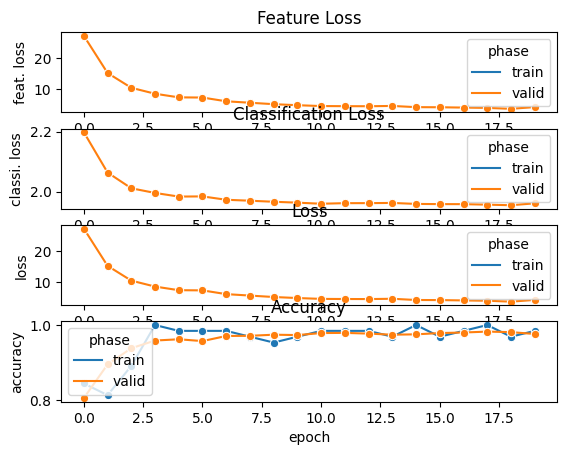

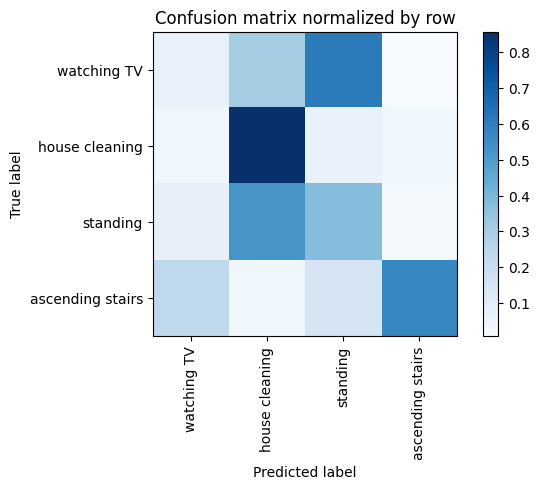

Overall accuracy: 0.526

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        standing       0.468      0.374      0.416      0.331       1842|	 house cleaning: 0.525,	watching TV: 0.076,	
  house cleaning       0.554      0.857      0.673      0.329       1832|	 standing: 0.066,	ascending stairs: 0.039,	
ascending stairs       0.832      0.572      0.678      0.192       1069|	 watching TV: 0.238,	standing: 0.150,	
     watching TV       0.115      0.073      0.089      0.148        825|	 standing: 0.611,	house cleaning: 0.309,	

----------------------------------------------------------------------------------------------------
     avg / total       0.514      0.526      0.502        1.0       5568|	      

{'accuracy': 0.5264008620689655, 'precision': 0.49189258207942715, 'recall': 0.46906544484188434, 'f1': 0.46389162109623927, 'samples': 5568, 'loss': 421657.33740234375, 'feat. loss': 421656.65283203125, 'classi. loss': 6854.22459411

Training Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.731



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.864



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.878



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.913



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.929



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.932



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.938



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.935



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.949



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.946



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.956



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.952



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.961



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.960



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.956



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.963



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.965



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.963



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.968



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.964



unseen:   0%|          | 0/86 [00:00<?, ?batch/s]

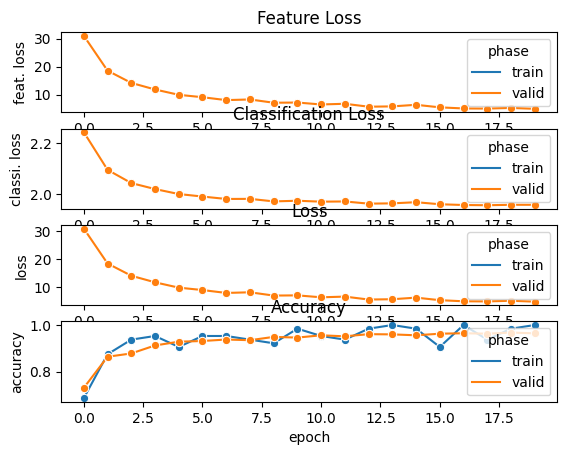

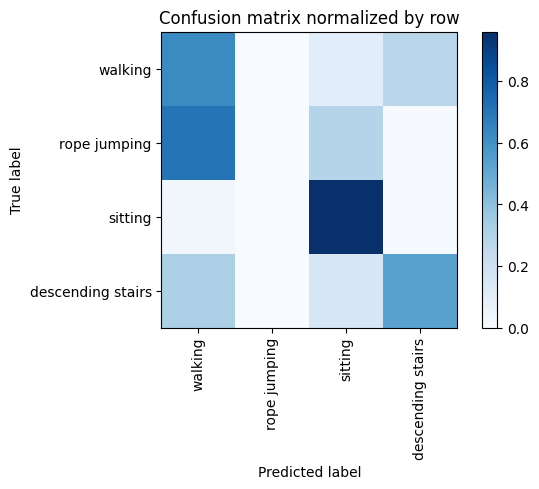

Overall accuracy: 0.666

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          walking       0.680      0.624      0.651      0.421       2317|	 descending stairs: 0.274,	sitting: 0.101,	
          sitting       0.771      0.961      0.855      0.325       1789|	 walking: 0.034,	descending stairs: 0.006,	
descending stairs       0.435      0.530      0.478      0.171        942|	 walking: 0.316,	sitting: 0.154,	
     rope jumping       0.000      0.000      0.000      0.083        456|	 walking: 0.706,	sitting: 0.289,	descending stairs: 0.004,	

----------------------------------------------------------------------------------------------------
      avg / total       0.611      0.666      0.634        1.0       5504|	      

{'accuracy': 0.6656976744186046, 'precision': 0.4714262419770535, 'recall': 0.5286697132025919, 'f1': 0.49596899314130016, 'samples': 5504, 'loss': 361360.9460449219, 'feat. loss': 361360.2861328125, 'classi. loss':

Training Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.686



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.838



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.881



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.906



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.904



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.931



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.945



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.958



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.956



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.960



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.965



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.968



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.966



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.967



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.973



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.970



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.977



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.968



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.969



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.977



unseen:   0%|          | 0/111 [00:00<?, ?batch/s]

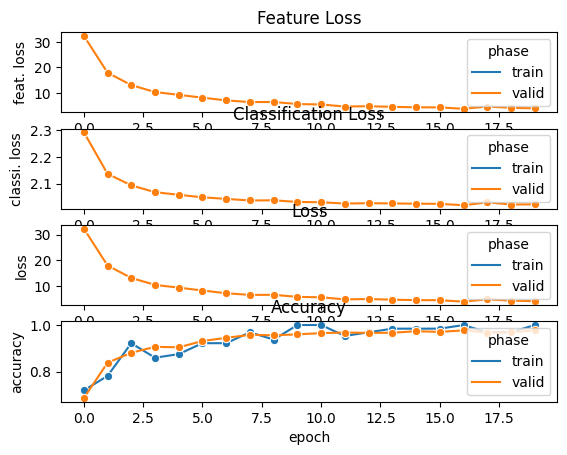

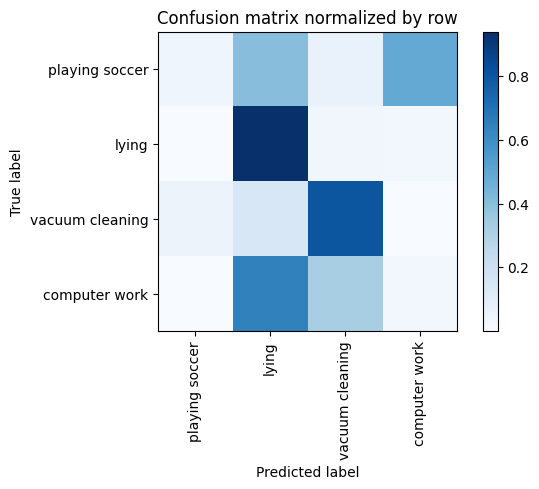

Overall accuracy: 0.455

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

  computer work       0.234      0.028      0.050      0.432       3067|	 lying: 0.645,	vacuum cleaning: 0.323,	
          lying       0.422      0.939      0.583      0.264       1875|	 vacuum cleaning: 0.033,	computer work: 0.028,	
vacuum cleaning       0.558      0.800      0.657      0.240       1705|	 lying: 0.144,	playing soccer: 0.052,	
 playing soccer       0.164      0.044      0.069      0.064        457|	 computer work: 0.490,	lying: 0.400,	vacuum cleaning: 0.066,	

----------------------------------------------------------------------------------------------------
    avg / total       0.357      0.455      0.338        1.0       7104|	      

{'accuracy': 0.4548141891891892, 'precision': 0.34447668577577284, 'recall': 0.45275102663419947, 'f1': 0.33980836938575565, 'samples': 7104, 'loss': 560357.3798828125, 'feat. loss': 560356.4594726562, 'classi. loss': 91

Training Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.737



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.835



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.848



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.880



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.895



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.904



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.932



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.938



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.937



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.949



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.950



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.955



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.950



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.953



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.948



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.960



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.955



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.962



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.962



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.966



unseen:   0%|          | 0/68 [00:00<?, ?batch/s]

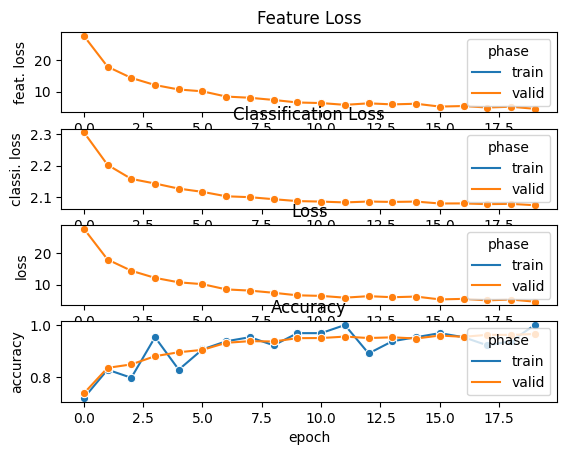

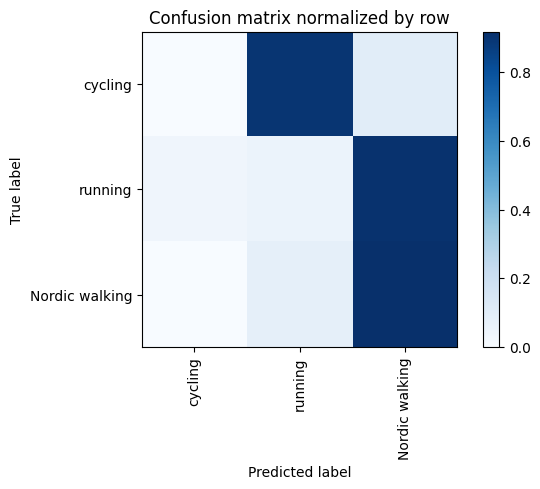

Overall accuracy: 0.396

                 precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Nordic walking       0.622      0.918      0.741      0.418       1820|	 running: 0.082,	cycling: 0.000,	
       cycling       0.029      0.001      0.001      0.365       1589|	 running: 0.899,	Nordic walking: 0.100,	
       running       0.031      0.054      0.040      0.217        943|	 Nordic walking: 0.910,	cycling: 0.036,	

----------------------------------------------------------------------------------------------------
   avg / total       0.277      0.396      0.319        1.0       4352|	      

{'accuracy': 0.39590992647058826, 'precision': 0.22717692164342718, 'recall': 0.3242813031641917, 'f1': 0.26074603143408775, 'samples': 4352, 'loss': 375654.8095703125, 'feat. loss': 375654.34716796875, 'classi. loss': 4640.17688369751, 'N': 3}
================ Fold-4 ================
Unseen Classes : ['ironing', 'car driving', 'folding laundry']
seen classes >  [0, 1,

Training Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.796



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.885



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.897



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.902



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.913



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.937



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.950



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.951



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.965



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.964



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.970



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.962



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.973



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.973



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.971



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.973



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.969



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.976



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.979



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.977



unseen:   0%|          | 0/60 [00:00<?, ?batch/s]

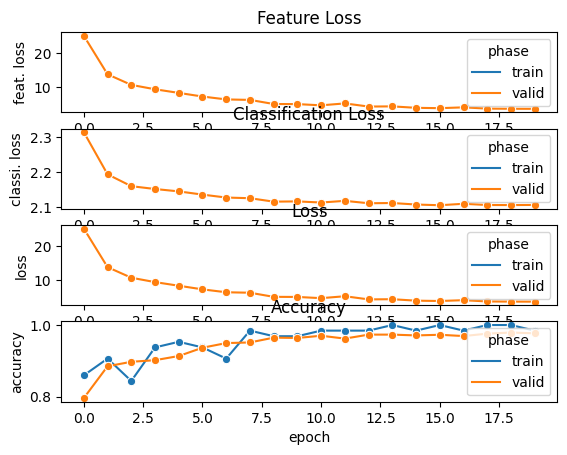

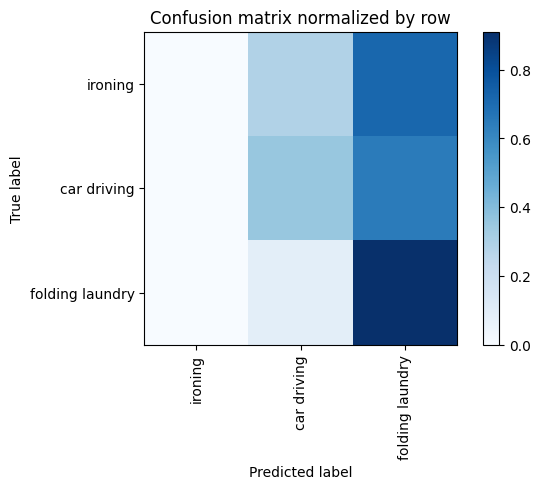

Overall accuracy: 0.280

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        ironing       0.000      0.000      0.000      0.607       2332|	 folding laundry: 0.715,	car driving: 0.285,	
folding laundry       0.305      0.910      0.457      0.253        970|	 car driving: 0.090,	ironing: 0.000,	
    car driving       0.203      0.355      0.258      0.140        538|	 folding laundry: 0.645,	ironing: 0.000,	

----------------------------------------------------------------------------------------------------
    avg / total       0.105      0.280      0.151        1.0       3840|	      

{'accuracy': 0.2796875, 'precision': 0.16915099219170115, 'recall': 0.42177595523703676, 'f1': 0.2382249364152156, 'samples': 3840, 'loss': 358815.55419921875, 'feat. loss': 358815.11474609375, 'classi. loss': 4368.353439331055, 'N': 3}
============== Overall Unseen Classes Performance ==============
accuracy     0.478580
precision    0.356676
recall    

In [ ]:
run['parameters'] = config
fold_metric_scores = []

for i, cs in enumerate(fold_cls_ids):
    print("="*16, f'Fold-{i}', "="*16)
    print(f'Unseen Classes : {fold_classes[i]}')

    data_dict = dataReader.generate(unseen_classes=cs, seen_ratio=config['seen_split'], unseen_ratio=config['unseen_split'], window_size=config['window_size'], window_overlap=config['overlap'], resample_freq=config['seq_len'])
    all_classes = dataReader.idToLabel
    seen_classes = data_dict['seen_classes']
    unseen_classes = data_dict['unseen_classes']
    print("seen classes > ", seen_classes)
    print("unseen classes > ", unseen_classes)
    train_n, seq_len, in_ft = data_dict['train']['X'].shape

    print("Initiate IMU datasets ...")
    # build IMU datasets
    train_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=semantic_space, action_classes=seen_classes, seq_len=100)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build seen eval_dt
    eval_dt = PAMAP2Dataset(data=data_dict['eval-seen']['X'], actions=data_dict['eval-seen']['y'], attributes=semantic_space, action_classes=seen_classes, seq_len=100)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build unseen test_dt
    test_dt = PAMAP2Dataset(data=data_dict['test']['X'], actions=data_dict['test']['y'], attributes=semantic_space, action_classes=unseen_classes, seq_len=100)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    
    # build model
    imu_config = {
        'in_ft':in_ft, 
        'd_model':config['d_model'], 
        'num_heads':config['num_heads'], 
        'ft_size':config['feat_size'], 
        'max_len':seq_len, 
        'n_classes':len(seen_classes)
    }
    model = IMUEncoder(**imu_config)
    model.to(device)

    # define run parameters 
    optimizer = Adam(model.parameters(), lr=config['lr'], weight_decay=1e-6)
    loss_module = {'class': nn.CrossEntropyLoss(reduction="sum"), 'feature': nn.L1Loss(reduction="sum")}
    best_acc = 0.0

    # train the model 
    train_data = []
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):
    
        train_metrics = train_step(model, train_dl, train_dt,optimizer, loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='train', loss_alpha=0.0001)
        train_metrics['epoch'] = epoch
        train_metrics['phase'] = 'train'
        train_data.append(train_metrics)
        log(i, 'train', train_metrics)

        eval_metrics = eval_step(model, eval_dl, eval_dt,loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='seen', loss_alpha=0.0001, print_report=False, show_plot=False)
        eval_metrics['epoch'] = epoch 
        eval_metrics['phase'] = 'valid'
        train_data.append(eval_metrics)
        log(i, 'eval', eval_metrics)
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        if eval_metrics['accuracy'] > best_acc:
            best_model = deepcopy(model.state_dict())
    
    train_df = pd.DataFrame().from_records(train_data)
    plot_curves(train_df)

    # replace by best model 
    model.load_state_dict(best_model)
    save_model(model,notebook_iden,model_iden,i)

    # run evaluation on unseen classes
    test_metrics = eval_step(model, test_dl,test_dt, loss_module, device, class_names=[all_classes[i] for i in unseen_classes], phase='unseen', loss_alpha=0.0001, print_report=True, show_plot=True)
    test_metrics['N'] = len(unseen_classes)
    fold_metric_scores.append(test_metrics)
    log('test', i, test_metrics)
    print(test_metrics)
    print("="*40)

print("="*14, "Overall Unseen Classes Performance", "="*14)
seen_score_df = pd.DataFrame.from_records(fold_metric_scores)
weighted_score_df = seen_score_df[["accuracy", "precision", "recall", "f1"]].multiply(seen_score_df["N"], axis="index")
final_results = weighted_score_df.sum()/seen_score_df['N'].sum()
print(final_results)
log('global', '',final_results.to_dict())
run.stop()
